<h1>1) Import All Library</h1>

In [1]:
import os
import json
import random
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import tqdm
import torch
import imgaug
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.multiprocessing as mp
import matplotlib.pyplot as plt

import datetime
import traceback
import shutil

import torch
import torchvision
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiplicativeLR, StepLR, MultiStepLR, ConstantLR, LinearLR, PolynomialLR, CosineAnnealingLR, LambdaLR, ChainedScheduler, ExponentialLR, SequentialLR, ReduceLROnPlateau, CyclicLR, CosineAnnealingWarmRestarts


import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


import cv2
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset
import albumentations as A
from imgaug import augmenters as iaa

from albumentations.pytorch import ToTensorV2

seed = 113
random.seed(seed)
imgaug.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


<h1>2. Set up baseline for training, validation, testing stage</h1>
<h1>2.1. Create Data loader for Rafdb dataset!</h1>

In [2]:
seg_raf = iaa.Sometimes(
        0.5,
	iaa.Sequential([iaa.Fliplr(p=0.5), iaa.Affine(rotate=(-25, 25))]),
        iaa.Sequential([iaa.RemoveSaturation(1),iaa.Affine(scale=(1.0, 1.05)) ])
)
seg_raftest2 = iaa.Sequential([iaa.RemoveSaturation(1),iaa.Affine(scale=(1.0, 1.05))])
seg_raftest1 = iaa.Sequential([iaa.Fliplr(p=0.5), iaa.Affine(rotate=(-25, 25))])


class RafDataSet(Dataset):
    def __init__(self, data_type, configs,  ttau = False, len_tta = 48, use_albumentation = True):
        self.use_albumentation = use_albumentation
        self.data_type = data_type
        self.configs = configs
        self.ttau = ttau
        self.len_tta = len_tta
        self.shape = (configs["image_size"], configs["image_size"])

        df = pd.read_csv(os.path.join(self.configs["raf_path"],configs["label_path"]), sep=' ', header=None,names=['name','label'])

        if data_type == 'train':
            self.data = df[df['name'].str.startswith('train')]
        else:
            self.data = df[df['name'].str.startswith('test')]

        #self.data = self.data[:100]

        file_names = self.data.loc[:, 'name'].values
        self.label = self.data.loc[:, 'label'].values - 1 # 0:Surprise, 1:Fear, 2:Disgust, 3:Happiness, 4:Sadness, 5:Anger, 6:Neutral

        _, self.sample_counts = np.unique(self.label, return_counts=True)
        # print(f' distribution of {data_type} samples: {self.sample_counts}')

        self.file_paths = []
        for f in file_names:
            f = f.split(".")[0]
            f = f +"_aligned.jpg"
            path = os.path.join(self.configs["raf_path"], self.configs["image_path"], f)
            self.file_paths.append(path)

        self.transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Imagenet
            #transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2675, 0.2565, 0.2761]), # VGGface2

        ]
        )
    def __len__(self):
        return len(self.file_paths)
    
    def is_ttau(self):
        return self.ttau == True

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        image = cv2.imread(path)
        image = image[:, :, ::-1]
#         print(image.shape)
        image = cv2.resize(image, self.shape)
        
        if self.data_type == "train":
            image = seg_raf(image = image)
            #image = my_data_augmentation(image.copy())
        if self.data_type == "test" and self.ttau == True:
            images1 = [seg_raftest1(image=image) for i in range(self.len_tta)]
            images2 = [seg_raftest2(image=image) for i in range(self.len_tta)]

            images = images1 + images2
            # images = [image for i in range(self._tta_size)]
            images = list(map(self.transform, images))
            label = self.label[idx]
        
            return images, label

        image = self.transform(image)
        label = self.label[idx]
        
        return image, label

<h1>2.2. Create format for Train stage(include validation stage)</h1>

In [3]:
def accuracy(y_pred, labels):
    with torch.no_grad():
        batch_size = labels.size(0)
        pred = torch.argmax(y_pred, dim=1)
        correct = pred.eq(labels).float().sum(0)
        acc = correct * 100 / batch_size
    return [acc]

def make_batch(images):
    if not isinstance(images, list):
        images = [images]
    return torch.stack(images, 0)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def create_CSV(output_csv_path):
  df = pd.DataFrame(columns=['epoch', 'learning_rate','accuracy', 'loss', 'val_accuracy', 'val_loss'])
  df.to_csv(output_csv_path, index=False)

def update_output_csv(output_csv_path, epoch, lr, accuracy, loss, val_accuracy, val_loss):
  df = pd.read_csv(output_csv_path)
  new_line = pd.DataFrame({'epoch':[epoch], 'learning_rate':[lr],'accuracy':[accuracy], 'loss':[loss], 'val_accuracy':[val_accuracy], 'val_loss':[val_loss]})
  new_line = new_line[df.columns]
  df = pd.concat([df, new_line], ignore_index=True)
  df.to_csv(output_csv_path, index=False)

class Trainer(object):
    """base class for trainers"""

    def __init__(self):
        pass


class RAFDB_Trainer(Trainer):
  def __init__(self, model, train_loader, val_loader, test_loader,test_loader_ttau, configs, wb = False, output_csv_path = '/kaggle/working/out.csv', initial_best_val_acc = 0.0):

    self.train_loader = train_loader
    self.val_loader = val_loader
    self.test_loader = test_loader
    self.test_loader_ttau = test_loader_ttau
    self.output_csv_path = output_csv_path
    create_CSV(output_csv_path = self.output_csv_path)
    self.configs = configs

    self.batch_size = configs["batch_size"]
    # self.epochs = configs["epochs"]
    self.learning_rate = configs["lr"]
    self.min_lr = configs["min_lr"]
    self.num_workers = configs["num_workers"]
    self.momentum = configs["momentum"]
    self.weight_decay = configs["weight_decay"]
    self.device = torch.device(configs["device"])
    self.max_plateau_count = configs["max_plateau_count"]
    self.max_epoch_num = configs["max_epoch_num"]
    self.distributed = configs["distributed"]
    self.optimizer_chose = configs["optimizer_chose"]
    self.lr_scheduler_chose = configs["lr_scheduler"]
    self.name_run_wandb = configs["name_run_wandb"]
    self.wb = wb

    #self.model = model.to(self.device)'cpu'
    '''if torch.cuda.is_available():
      self.device = torch.device('cuda:0')  # Use CUDA device 
    else:
      self.device = torch.device('cpu')
      print("CUDA is not available, falling back to CPU.")'''
    self.model = model.to(self.device)

# Move the model to the device
    '''try:
      model = model.to(self.device)
    except Exception as e:
      print("Error:", e)'''

    self.train_loss_list = []
    self.train_acc_list = []
    self.val_loss_list = []
    self.val_acc_list = []
    self.best_train_acc = 0.0
    self.best_val_acc = initial_best_val_acc
    self.best_train_loss = 0.0
    self.best_val_loss = 0.0
    self.test_acc = 0.0
    self.test_acc_ttau = 0.0
    self.plateau_count = 0
    #self.current_epoch_num = 0
    self.current_epoch_num = configs["current_epoch_num"]
    # Set information for training
    self.start_time = datetime.datetime.now()

    self.checkpoint_dir = "/kaggle/working/"

    '''self.checkpoint_path = os.path.join(self.checkpoint_dir, "{}_{}_{}".format
                                        (self.configs["project_name"], self.configs["model"], self.start_time.strftime("%Y%b%d_%H.%M"),))'''

    self.checkpoint_path = os.path.join(self.checkpoint_dir,"ResnetDuck_Cbam_cuaTuan")

    if self.distributed == 1:
            torch.distributed.init_process_group(backend="nccl")
            self.model = nn.parallel.DistributedDataParallel(self.model)
            print("Let's use", torch.cuda.device_count(), "GPUs!")

            self.train_ds = DataLoader(
                self.train_loader,
                batch_size=self.batch_size,
                num_workers=self.num_workers,
                pin_memory=True,
                shuffle=True,
                worker_init_fn=lambda x: np.random.seed(x),
            )
            self.val_ds = DataLoader(
                self.val_loader,
                batch_size=self.batch_size,
                num_workers=self.num_workers,
                pin_memory=True,
                shuffle=False,
                worker_init_fn=lambda x: np.random.seed(x),
            )

            self.test_ds = DataLoader(
                self.test_loader,
                batch_size=1,
                num_workers=self.num_workers,
                pin_memory=True,
                shuffle=False,
                worker_init_fn=lambda x: np.random.seed(x),
            )
    else:

      self.train_ds = DataLoader(self.train_loader,batch_size=self.batch_size,num_workers=self.num_workers,
                        pin_memory=True, shuffle=True)
      self.val_ds = DataLoader(self.val_loader, batch_size = self.batch_size, num_workers=self.num_workers,
                      pin_memory=True, shuffle=False)
      self.test_ds = DataLoader(self.test_loader, batch_size= 1,num_workers=self.num_workers,
                      pin_memory=True, shuffle=False)
    
    
    self.criterion = nn.CrossEntropyLoss().to(self.device)

    if self.optimizer_chose == "RAdam":
      print("The selected optimizer is RAdam")
      self.optimizer = torch.optim.RAdam(
        params=self.model.parameters(),
        lr=self.learning_rate,
        weight_decay=self.weight_decay,
#       amsgrad = True,
    )
    elif self.optimizer_chose == "SGD":
      print("The selected optimizer is SGD")
      self.optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.9)
    elif self.optimizer_chose == "RMSprop":
      print("The selected optimizer is RMSprop")
      self.optimizer = torch.optim.RMSprop(
        params=model.parameters(),
        lr=self.learning_rate,
        weight_decay=self.weight_decay,
        momentum=0.9,
        alpha=0.99,
        eps=1e-8)
    elif self.optimizer_chose == "Adam":
      print("The selected optimizer is Adam")
      self.optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=self.learning_rate,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=self.weight_decay)
    elif self.optimizer_chose == "AdamW":
      print("The selected optimizer is AdamW")
      self.optimizer = torch.optim.AdamW(
          params=self.model.parameters(),
          lr=self.learning_rate,
          betas=(0.9, 0.999),
          eps=1e-8,
          weight_decay=self.weight_decay)
    elif self.optimizer_chose == "Adamax":
      print("The selected optimizer is Adamax")
      self.optimizer = torch.optim.Adamax(
          params=self.model.parameters(),
          lr=self.learning_rate,
          betas=(0.9, 0.999),
          eps=1e-8,
          weight_decay=self.weight_decay)
    elif self.optimizer_chose == "Adagrad":
      print("The selected optimizer is Adagrad")
      self.optimizer = torch.optim.Adagrad(
          params=self.model.parameters(),
          lr=self.learning_rate,
          lr_decay=0.001,  
          weight_decay=self.weight_decay,  
          initial_accumulator_value=0.1,  
          eps=1e-8
      )
    else:  #default ="RAdam"
      print("The selected optimizer is RAdam")
      self.optimizer = torch.optim.RAdam(
        params=self.model.parameters(),
        lr=self.learning_rate,
        weight_decay=self.weight_decay,
#       amsgrad = True,
    )
      
      
    if self.lr_scheduler_chose == "ReduceLROnPlateau":
      self.scheduler = ReduceLROnPlateau(
        self.optimizer,
        patience=self.configs["plateau_patience"],
        min_lr=self.min_lr,
        # factor = torch.exp(torch.Tensor([-0.1])),
        factor = 0.5,
      )
      print("The selected learning_rate scheduler strategy is ReduceLROnPlateau")
    elif self.lr_scheduler_chose == "MultiStepLR":
      milestones = [x for x in range(5, 120, 5)]
      self.scheduler = MultiStepLR(self.optimizer, milestones=milestones, gamma=0.5,  verbose=True)
      print("The selected learning_rate scheduler strategy is MultiStepLR")

    elif self.lr_scheduler_chose == "ExponentialLR":
      self.scheduler = ExponentialLR(self.optimizer, gamma = 0.8,  verbose=True)
      print("The selected learning_rate scheduler strategy is ExponentialLR")

    elif self.lr_scheduler_chose == "PolynomialLR":
      self.scheduler = PolynomialLR(self.optimizer, total_iters=30, power=2,  verbose=True)
      print("The selected learning_rate scheduler strategy is PolynomialLR")

    elif self.lr_scheduler_chose == "CosineAnnealingLR":
      self.scheduler = CosineAnnealingLR(self.optimizer, T_max=10, eta_min=self.min_lr,  verbose=True)
      print("The selected learning_rate scheduler strategy is CosineAnnealingLR")

    elif self.lr_scheduler_chose == "CosineAnnealingWarmRestarts":
      self.scheduler = CosineAnnealingWarmRestarts(self.optimizer, T_0=5, T_mult=2, eta_min=self.min_lr,  verbose=True)
      print("The selected learning_rate scheduler strategy is CosineAnnealingWarmRestarts")

    else: #default ="ReduceLROnPlateau"
      self.lr_scheduler_chose = 'None'
      lambda_lr = lambda epoch: 1.0  # Không thay đổi learning rate
      self.scheduler = LambdaLR(self.optimizer, lr_lambda=lambda_lr)
      print(f"No choosing Learning rate scheduler(lr={self.learning_rate})")

       
  def init_wandb(self):
    #set up wandb for training
    if self.wb == True:
      try:
        print("------------SETTING UP WANDB--------------")
        import wandb
        self.wandb = wandb
        self.wandb.login(key=self.configs["wandb_api_key"])
        print("------Wandb Init-------")

        self.wandb.init(
            project = self.configs["project_name"],
            name = self.name_run_wandb,
            config = self.configs
        )
        self.wandb.watch(self.model, self.criterion, log="all", log_freq=10)
        print()
        print("-----------------------TRAINING MODEL-----------------------")
      except:
          print("--------Can not import wandb-------")

    # return wandb
  def step_per_train(self):
    # if self.wb == True:
    #   self.wandb.watch(model)

    self.model.train()
    train_loss = 0.0
    train_acc = 0.0

    for i, (images, labels) in tqdm.tqdm(
        enumerate(self.train_ds), total = len(self.train_ds), leave = True, colour = "blue", desc = f"Epoch {self.current_epoch_num}",
        bar_format="{desc}: {percentage:3.0f}%|{bar:50}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"
    ):

      # Move images to GPU before feeding them to the model, to fix error happen : Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
      self.model = self.model.cuda()
      
      images = images.cuda(non_blocking = True)
      labels = labels.cuda(non_blocking = True)

      # compute output, accuracy and get loss
      y_pred = self.model(images)
    
      loss = self.criterion(y_pred, labels)
      acc = accuracy(y_pred, labels)[0]
      

      train_loss += loss.item()
      train_acc += acc.item()

      # compute gradient and do SGD step
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # write wandb
      metric = {
          " Loss" : train_loss / (i+1),
          " Accuracy" :train_acc / (i+1),
          " epochs" : self.current_epoch_num,
          " Learning_rate" : get_lr(self.optimizer)
      }
      if self.wb == True and i <= len(self.train_ds):
            self.wandb.log(metric)

      
    i += 1
    self.train_loss_list.append(train_loss / i)
    self.train_acc_list.append(train_acc / i)


    print(" Loss: {:.4f}".format(self.train_loss_list[-1]), ", Accuracy: {:.2f}%".format(self.train_acc_list[-1]))

  def step_per_val(self):
    self.model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
      for i, (images, labels) in tqdm.tqdm(
          enumerate(self.val_ds), total = len(self.val_ds), leave = True, colour = "green", desc = "        ",
          bar_format="{desc} {percentage:3.0f}%|{bar:30}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"
      ):
        images = images.cuda(non_blocking = True)
        labels = labels.cuda(non_blocking = True)

        # compute output, accuracy and get loss
        y_pred = self.model(images)

        loss = self.criterion(y_pred, labels)
        acc = accuracy(y_pred, labels)[0]

        val_loss += loss.item()
        val_acc += acc.item()

      i += 1
      self.val_loss_list.append(val_loss / i)
      self.val_acc_list.append(val_acc / i)

      print(" Val_Loss: {:.4f}".format(self.val_loss_list[-1]),", Val_Accuracy: {:.2f}%".format(self.val_acc_list[-1]),", Learning_rate: {:.7}".format(self.optimizer.param_groups[0]['lr']))

      # write wandb
      if self.wb == True:
        metric = {
            " Val_Loss" : self.val_loss_list[-1],
            " Val_Accuracy" :self.val_acc_list[-1],
            # "Learning_rate" : self.learning_rate
        }
        self.wandb.log(metric)

      

  def acc_on_test(self):
    self.model.eval()
    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
      for i, (images, labels) in tqdm.tqdm(
          enumerate(self.test_ds), total = len(self.test_ds), leave = True, colour = "green", desc = "        ",
          bar_format="{desc} {percentage:3.0f}%|{bar:30}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"
      ):
        images = images.cuda(non_blocking = True)
        labels = labels.cuda(non_blocking = True)

        # compute output, accuracy and get loss
        y_pred = self.model(images)

        loss = self.criterion(y_pred, labels)
        acc = accuracy(y_pred, labels)[0]

        test_loss += loss.item()
        test_acc += acc.item()

        # print(i)
      i += 1
      test_loss = (test_loss / i)
      test_acc = (test_acc / i)

      print("Accuracy on Test_ds: {:.3f}".format(test_acc))
      if self.wb == True:
        self.wandb.log({"Test_accuracy": test_acc})
      return test_acc

  def acc_on_test_ttau(self):
    self.model.eval()
    test_acc = 0.0
    # print(" Calculate accuracy on Test_ds with TTAU...!")

    # write log for testting

    with torch.no_grad():
      for idx in tqdm.tqdm(
          range(len(self.test_loader_ttau)), total = len(self.test_loader_ttau), leave = False
      ):

        images, labels = self.test_loader_ttau[idx]
        labels = torch.LongTensor([labels])

        images = make_batch(images)
        images = images.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)

        y_pred = self.model(images)
        y_pred = F.softmax(y_pred, 1)

        y_pred = torch.sum(y_pred, 0)

        y_pred = torch.unsqueeze(y_pred, 0)

        acc = accuracy(y_pred, labels)[0]

        test_acc += acc.item()

      test_acc = test_acc / (idx + 1)
    print("Accuracy on Test_ds with TTAU: {:.3f}".format(test_acc))
    if self.wb == True:
      self.wandb.log({"Testta_accuracy": test_acc})

    return test_acc

  def Train_model(self):
    self.init_wandb()
    #self.scheduler.step(100 - self.best_val_acc)
    try:
      while not self.stop_train():
        self.update_epoch_num()
        self.step_per_train()
        self.step_per_val()

        self.update_state_training()

    except KeyboardInterrupt:
      traceback.print_exc()
      pass
    # Stop training
    try:
      #loading best model
      state = torch.load(self.checkpoint_path)
      self.model.load_state_dict(state["net"])
      print("----------------------Cal on Test-----------------------")
      self.test_acc = self.acc_on_test()
      self.test_acc_ttau = self.acc_on_test_ttau()
      self.save_weights()

    except Exception as e:
      traceback.prtin_exc()
      pass

    consume_time = str(datetime.datetime.now() - self.start_time)
    print("----------------------SUMMARY-----------------------")
    print(" After {} epochs and {} plateau count, consume {}".format((self.current_epoch_num), (self.plateau_count),consume_time[:-7]))
    print(" Best Accuracy on Train: {:.3f} ".format(self.best_train_acc))
    print(" Best Accuracy on Val: {:.3f} ".format(self.best_val_acc))
    print(" Best Accuracy on Test: {:.3f} ".format(self.test_acc))
    print(" Best Accuracy on Test with tta: {:.3f} ".format(self.test_acc_ttau))
    return self.model, self.best_val_acc

  #set up for training (update epoch, stopping training, write logging)
  def update_epoch_num(self):
    self.current_epoch_num += 1

  def stop_train(self):
    return (
        self.plateau_count > self.max_plateau_count or
        self.current_epoch_num > self.max_epoch_num
    )
  
  def update_state_training(self):
    if self.val_acc_list[-1] > self.best_val_acc:
      self.save_weights()
      self.plateau_count = 0
      self.best_val_acc = self.val_acc_list[-1]
      self.best_val_loss = self.val_loss_list[-1]
      self.best_train_acc = self.train_acc_list[-1]
      self.best_train_loss = self.train_loss_list[-1]
      print(f'Weight was updated because val_accuracy get highest(={self.val_acc_list[-1]})')
    else:
      self.plateau_count += 1
    
    #update CSV
    update_output_csv(output_csv_path = self.output_csv_path, 
                      epoch=len(self.val_acc_list),
                      lr = self.optimizer.param_groups[0]['lr'], 
                      accuracy = self.train_acc_list[-1],
                      loss = self.train_loss_list[-1],
                      val_accuracy = self.val_acc_list[-1],
                      val_loss = self.val_loss_list[-1])

# 100 - self.best_val_acc
    if self.lr_scheduler_chose == "ReduceLROnPlateau":
      self.scheduler.step(self.val_acc_list[-1])
    else:
      self.scheduler.step()

    if self.optimizer.param_groups[0]['lr'] < self.min_lr:
      self.optimizer.param_groups[0]['lr'] = self.min_lr
#100 - self.best_val_acc

  def save_weights(self):
    state_dict = self.model.state_dict()

    state = {
        **self.configs,
        "net": state_dict,
        "best_val_loss": self.best_val_loss,
        "best_val_acc": self.best_val_acc,
        "best_train_loss": self.best_train_loss,
        "best_train_acc": self.best_train_acc,
        "train_loss_list": self.train_loss_list,
        "val_loss_list": self.val_loss_list,
        "train_acc_list": self.train_acc_list,
        "val_acc_list": self.val_acc_list,
        "test_acc": self.test_acc,
        "optimizer": self.optimizer.state_dict(),
    }

    torch.save(state, self.checkpoint_path)

<h1>2.3. Setup Baseline for Testing Stage</h1>


In [4]:
def plot_confusion_matrix(model, testloader,title = "My model"):
    model.cuda()
    model.eval()

    correct = 0
    total = 0
    all_target = []
    all_output = []

    # test_set = fer2013("test", configs, tta=True, tta_size=8)
    # test_set = fer2013('test', configs, tta=False, tta_size=0)

    with torch.no_grad():
        for idx in tqdm.tqdm(range(len(testloader)), total=len(testloader), leave=False):
            images, labels = testloader[idx]

            images = make_batch(images)
            images = images.cuda(non_blocking=True)

            preds = model(images).cpu()
            preds = F.softmax(preds, 1)

            # preds.shape [tta_size, 7]
            preds = torch.sum(preds, 0)
            preds = torch.argmax(preds, 0)
            preds = preds.item()
            labels = labels.item()
            total += 1
            correct += preds == labels

            all_target.append(labels)
            all_output.append(preds)

    
    cf_matrix = confusion_matrix(all_target, all_output)
    cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    class_names = ["Surprise", "Fear", "Disgust", "Happy", "Sad", "Anger", "Neutral"]
    #0:Surprise, 1:Fear, 2:Disgust, 3:Happiness, 4:Sadness, 5:Anger, 6:Neutral

    # Create pandas dataframe
    dataframe = pd.DataFrame(cmn, index=class_names, columns=class_names)
    plt.figure(figsize=(8, 6))
    
    # Create heatmap
    sns.heatmap(dataframe, annot=True, cbar=True,cmap="Blues",fmt=".2f")
    
    plt.title(title), plt.tight_layout()
    
    plt.ylabel("True Class", fontsize=12), 
    plt.xlabel("Predicted Class", fontsize=12)
    plt.show()

    plt.savefig("DuckAttention_imagenet_RAFDB_CM.pdf")
    plt.close()

    print(classification_report(all_target, all_output, target_names=class_names))

def training_process_statistic(rs_path):
    import pandas as pd
    result = pd.read_csv(rs_path)
    plt.figure(figsize=(10, 8))
    
    # Plotting Accuracy
    plt.subplot(3, 3, 1)
    plt.plot(result['epoch'], result['accuracy'], label='Training Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(3, 3, 2)
    plt.plot(result['epoch'], result['val_accuracy'], label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('val_accuracy')
    plt.legend()
    
    plt.subplot(3, 3, 3)
    plt.plot(result['epoch'], result['loss'], label='Training Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()
    
    plt.subplot(3, 3, 4)
    plt.plot(result['epoch'], result['val_loss'], label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('val_loss')
    plt.legend()

    plt.subplot(3, 3, 5)
    plt.plot(result['epoch'], result['epoch'], label='epoch', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Epoch')
    plt.legend()
    
    plt.subplot(3, 3, 6)
    plt.plot(result['epoch'], result['learning_rate'], label='Learning Rate', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
   

<h1>3. Create Resnet50, Resnet50+Cbam model</h1>

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import pickle
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
    "resnet101",
    "resnet152",
    "resnext50_32x4d",
    "resnext101_32x8d",
    "wide_resnet50_2",
    "wide_resnet101_2",
]


model_urls = {
    "resnet18": "https://download.pytorch.org/models/resnet18-5c106cde.pth",
    "resnet34": "https://download.pytorch.org/models/resnet34-333f7ec4.pth",
    "resnet50": "https://download.pytorch.org/models/resnet50-19c8e357.pth",
    "resnet101": "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth",
    "resnet152": "https://download.pytorch.org/models/resnet152-b121ed2d.pth",
    "resnext50_32x4d": "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth",
    "resnext101_32x8d": "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth",
    "wide_resnet50_2": "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth",
    "wide_resnet101_2": "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth",
    #"vggface2": "https://onedrive.live.com/download?cid=D07B627FBE5CFFFA&resid=D07B627FBE5CFFFA%21587&authkey=APXT_JMvytW7cgk",
    ##"vggface2": "/kaggle/input/resnet50-vggface2-weight/resnet50_scratch_weight.pkl",
    "vggface2_ft": "/kaggle/input/resnet50-vggface2-weight/resnet50_ft_weight123.pkl",
    #"vggface2_ft": "/kaggle/input/resnet50-vggface2-freezed-except-cbam/Resnet50_trained_FER2013"
}

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class ConvBlock(nn.Module):
    """
    Standard convolution block with Batch normalization and activation.

    Parameters
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple(int, int)
        Convolution window size.
    stride : int or tuple(int, int)
        Strides of the convolution.
    padding : int or tuple(int, int) or tuple(int, int, int, int)
        Padding value for convolution layer.
    dilation : int or tuple(int, int), default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layer.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int | tuple[int, int],
                 stride: int | tuple[int, int],
                 padding: int | tuple[int, int] | tuple[int, int, int, int],
                 dilation: int | tuple[int, int] = 1,
                 groups: int = 1,
                 bias: bool = False,
                 use_bn: bool = True,
                 bn_eps: float = 1e-5,
                 activation = None):
        super(ConvBlock, self).__init__()
        self.activate = (activation is not None)
        self.use_bn = use_bn
        self.use_pad = (isinstance(padding, (list, tuple)) and (len(padding) == 4))

        if self.use_pad:
            self.pad = nn.ZeroPad2d(padding=padding)
            padding = 0
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias)
        if self.use_bn:
            self.bn = nn.BatchNorm2d(
                num_features=out_channels,
                eps=bn_eps)
        if self.activate:
            self.activ = get_activation_layer(activation)

    def forward(self, x):
        if self.use_pad:
            x = self.pad(x)
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        if self.activate:
            x = self.activ(x)
        return x

def conv7x7_block(in_channels: int,
                  out_channels: int,
                  stride: int | tuple[int, int] = 1,
                  padding: int | tuple[int, int] | tuple[int, int, int, int] = 3,
                  dilation: int | tuple[int, int] = 1,
                  groups: int = 1,
                  bias: bool = False,
                  use_bn: bool = True,
                  bn_eps: float = 1e-5,
                  activation = None) -> nn.Module:
    
    return ConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=7,
        stride=stride,
        padding=padding,
        dilation=dilation,
        groups=groups,
        bias=bias,
        use_bn=use_bn,
        bn_eps=bn_eps,
        activation=activation)


class MLP(nn.Module):
    """
    Multilayer perceptron block.

    Parameters
    ----------
    channels : int
        Number of input/output channels.
    reduction_ratio : int, default 16
        Channel reduction ratio.
    """
    def __init__(self,
                 channels: int,
                 reduction_ratio: int = 16):
        super(MLP, self).__init__()
        mid_channels = channels // reduction_ratio

        self.fc1 = nn.Linear(
            in_features=channels,
            out_features=mid_channels)
        self.activ = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(
            in_features=mid_channels,
            out_features=channels)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.activ(x)
        x = self.fc2(x)
        return x


class ChannelGate(nn.Module):
    """
    CBAM channel gate block.

    Parameters
    ----------
    channels : int
        Number of input/output channels.
    reduction_ratio : int, default 16
        Channel reduction ratio.
    """
    def __init__(self,
                 channels: int,
                 reduction_ratio: int = 16):
        super(ChannelGate, self).__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.max_pool = nn.AdaptiveMaxPool2d(output_size=(1, 1))
        self.mlp = MLP(
            channels=channels,
            reduction_ratio=reduction_ratio)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        att1 = self.avg_pool(x)
        att1 = self.mlp(att1)
        att2 = self.max_pool(x)
        att2 = self.mlp(att2)
        att = att1 + att2
        att = self.sigmoid(att)
        att = att.unsqueeze(2).unsqueeze(3).expand_as(x)
        x = x * att
        return x


class SpatialGate(nn.Module):
    """
    CBAM spatial gate block.
    """
    def __init__(self):
        super(SpatialGate, self).__init__()
        self.conv = conv7x7_block(
            in_channels=2,
            out_channels=1,
            activation=None)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        att1 = x.max(dim=1)[0].unsqueeze(1)
        att2 = x.mean(dim=1).unsqueeze(1)
        att = torch.cat((att1, att2), dim=1)
        att = self.conv(att)
        att = self.sigmoid(att)
        x = x * att
        return x


class CbamBlock(nn.Module):
    """
    CBAM attention block for CBAM-ResNet.

    Parameters
    ----------
    channels : int
        Number of input/output channels.
    reduction_ratio : int, default 16
        Channel reduction ratio.
    """
    def __init__(self,
                 channels: int,
                 reduction_ratio: int = 16):
        super(CbamBlock, self).__init__()
        self.ch_gate = ChannelGate(
            channels=channels,
            reduction_ratio=reduction_ratio)
        self.sp_gate = SpatialGate()

    def forward(self, x):
        x = self.ch_gate(x)
        x = self.sp_gate(x)
        return x


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam = False):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        self.use_cbam = use_cbam
        if self.use_cbam == True:
            self.CbamBlock = CbamBlock(channels = planes * 4)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if self.use_cbam == True:
            out = self.CbamBlock(out)
        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, include_top=True, use_cbam = False):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.include_top = include_top

        self.use_cbam = use_cbam
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.dropout = nn.Dropout(p=0.5)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam = self.use_cbam ))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam = self.use_cbam ))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = self.dropout(x)
        
        if not self.include_top:
            return x
        
        x = x.view(x.size(0), -1)
        #x = self.dropout(x)
        x = self.fc(x)
        return x


def _resnet(arch, block, layers, pretrained, progress, use_cbam = False, **kwargs):
    model = ResNet(block, layers, use_cbam = use_cbam, **kwargs)
    if pretrained == True:
        print(f'load weight in {model_urls[arch]}')
        if 'vggface2' in arch:
            with open(model_urls[arch], 'rb') as f:
                state_dict = pickle.load(f)
                
            for key in state_dict.keys():
                state_dict[key] = torch.from_numpy(state_dict[key])
        else:
            state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict, strict=False)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = _resnet(
        "resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress,num_classes = 1000, **kwargs
    )

    # model.fc = nn.Linear(512, kwargs['num_classes'])
    model.fc = nn.Linear(512, 7)
    return model


def resnet34(pretrained=True, progress=True, out_classes = 7, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = _resnet(
        "resnet34", BasicBlock, [3, 4, 6, 3], pretrained, progress,num_classes = 1000 ,**kwargs
    )
    model.fc = nn.Linear(512, out_classes)
    return model


def resnet50(pretrained=True, progress=True, out_classes = 7, use_cbam = False, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = _resnet(
        "resnet50", Bottleneck, [3, 4, 6, 3], pretrained, progress,num_classes = 1000, use_cbam = use_cbam, **kwargs
    )
    model.fc = nn.Linear(2048, out_classes)
    return model

def resnet50_vggface2_ft(pretrained=True, progress=True,out_classes = 7,  use_cbam = False, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = _resnet(
        "vggface2_ft", Bottleneck, [3, 4, 6, 3], pretrained, progress,num_classes=8631, use_cbam = use_cbam, **kwargs
    )
    model.fc = nn.Linear(2048, out_classes)
    print('model resnet50 with pre-train on vggface2(trained on MS1M, and then fine-tuned on VGGFace2) is done!')
    return model

In [6]:
def get_model_resnet(name='ResNet50', pretrained = False):
    if name == 'ResNet50_CBAM':
         model = resnet50_vggface2_ft(pretrained = pretrained, use_cbam = True)
         print('actived trained_weight')
         state = torch.load('/kaggle/input/resnet50-vggface2-freezed-except-cbam/ResnetDuck_Cbam_cuaTuan84', weights_only=True)
         model.load_state_dict(state['net'])
    else: #resnet50(default)
        model = resnet50_vggface2_ft(pretrained = pretrained, use_cbam = False)
    return model

<h1>4. Setup Baseline(preparing Train stage)</h1>
<h1>4.1 Initial hyperparameter</h1>

In [7]:
configs = {
    "raf_path": "/kaggle/input/rafdb-basic",
    "image_path": "rafdb_basic/Image/aligned/",
    "label_path": "rafdb_basic/EmoLabel/list_patition_label.txt",
    "image_size": 224,
    "n_channels": 3,
    "n_classes": 7,
    "model": "ResNet50_CBAM", 
    "lr": 1e-04,
    "min_lr": 1e-07,
    "weighted_loss": 0,
    "device": "cuda:0",
    "momentum": 0.9,
    "weight_decay": 0.0001,
    "distributed": 0,
    "batch_size": 64,
    "num_workers": 2,
    "max_plateau_count": 50,
    "max_epoch_num": 1000,
    "plateau_patience": 10,
    "steplr": 50,
    "optimizer_chose":"RAdam",
    "lr_scheduler":"ReduceLROnPlateau",
    "project_name": "residual_cbam_resnet2024",
    "wandb_api_key": "",
    "use_pretrained":False,
    "current_epoch_num":0,
    "rs_dir":"/kaggle/working/ResnetDuck_Cbam_cuaTuan",
    "name_run_wandb":"Tuan_dep_trai_ne",
    "freeze_cbam":False,
}

<h1>4.2. Activating and checking model</h1>

In [8]:
train_loader = RafDataSet( "train", configs)
test_loader_ttau = RafDataSet("test", configs, ttau = True, len_tta = 10) 
test_loader = RafDataSet("test", configs, ttau = False, len_tta = 48) 

model = get_model_resnet(name = configs['model'], pretrained = configs['use_pretrained'])

# for name, layer in model.named_children():
#     print(f"{name}: {layer}")

if configs['freeze_cbam'] == True:
    print("go freeze")
    layers = [3, 4, 6, 3]  
    layer_names = ['layer1', 'layer2', 'layer3', 'layer4']
    
    for name, layer in model.named_children():
        if isinstance(layer, torch.nn.Module):  # Only consider actual layers
            if name == 'fc':
                continue
            for param in layer.parameters():
                param.requires_grad = False

    # Unfreeze CBAM blocks as specified by the layers
    for i, layer_name in enumerate(layer_names):
        if hasattr(model, layer_name):
            layer = getattr(model, layer_name)
            for idx in range(layers[i]):
                for param in layer[idx].CbamBlock.parameters():
                    param.requires_grad = True
            
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")


model resnet50 with pre-train on vggface2(trained on MS1M, and then fine-tuned on VGGFace2) is done!
actived trained_weight
conv1.weight: True
bn1.weight: True
bn1.bias: True
layer1.0.conv1.weight: True
layer1.0.bn1.weight: True
layer1.0.bn1.bias: True
layer1.0.conv2.weight: True
layer1.0.bn2.weight: True
layer1.0.bn2.bias: True
layer1.0.conv3.weight: True
layer1.0.bn3.weight: True
layer1.0.bn3.bias: True
layer1.0.downsample.0.weight: True
layer1.0.downsample.1.weight: True
layer1.0.downsample.1.bias: True
layer1.0.CbamBlock.ch_gate.mlp.fc1.weight: True
layer1.0.CbamBlock.ch_gate.mlp.fc1.bias: True
layer1.0.CbamBlock.ch_gate.mlp.fc2.weight: True
layer1.0.CbamBlock.ch_gate.mlp.fc2.bias: True
layer1.0.CbamBlock.sp_gate.conv.conv.weight: True
layer1.0.CbamBlock.sp_gate.conv.bn.weight: True
layer1.0.CbamBlock.sp_gate.conv.bn.bias: True
layer1.1.conv1.weight: True
layer1.1.bn1.weight: True
layer1.1.bn1.bias: True
layer1.1.conv2.weight: True
layer1.1.bn2.weight: True
layer1.1.bn2.bias: True


<h1>4.3. Training stage is running</h1>

In [9]:
trainer = RAFDB_Trainer(model, train_loader, test_loader, test_loader, test_loader_ttau, configs)
trainer.Train_model()

The selected optimizer is RAdam
The selected learning_rate scheduler strategy is ReduceLROnPlateau


Epoch 1: 100%|██████████████████████████████████████████████████| 192/192 [01:34<00:00]

 Loss: 0.4661 , Accuracy: 83.54%



         100%|██████████████████████████████| 48/48 [00:18<00:00]


 Val_Loss: 0.4833 , Val_Accuracy: 83.53% , Learning_rate: 0.0001
Weight was updated because val_accuracy get highest(=83.53081607818604)


Epoch 2: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.3834 , Accuracy: 86.79%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.5211 , Val_Accuracy: 83.75% , Learning_rate: 0.0001
Weight was updated because val_accuracy get highest(=83.7521702448527)


Epoch 3: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.3288 , Accuracy: 88.57%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5860 , Val_Accuracy: 82.13% , Learning_rate: 0.0001



Epoch 4: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.2652 , Accuracy: 90.43%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5541 , Val_Accuracy: 83.60% , Learning_rate: 0.0001



Epoch 5: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.2490 , Accuracy: 91.26%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6689 , Val_Accuracy: 80.53% , Learning_rate: 0.0001



Epoch 6: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.2155 , Accuracy: 92.39%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.5048 , Val_Accuracy: 85.46% , Learning_rate: 0.0001
Weight was updated because val_accuracy get highest(=85.46440982818604)


Epoch 7: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.2097 , Accuracy: 92.82%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.4926 , Val_Accuracy: 85.55% , Learning_rate: 0.0001
Weight was updated because val_accuracy get highest(=85.5490452448527)


Epoch 8: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.1906 , Accuracy: 93.48%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.5079 , Val_Accuracy: 85.67% , Learning_rate: 0.0001
Weight was updated because val_accuracy get highest(=85.67057291666667)


Epoch 9: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.1594 , Accuracy: 94.53%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.7009 , Val_Accuracy: 80.01% , Learning_rate: 0.0001



Epoch 10: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.1679 , Accuracy: 94.17%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.5034 , Val_Accuracy: 86.12% , Learning_rate: 0.0001
Weight was updated because val_accuracy get highest(=86.1154514948527)


Epoch 11: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.1538 , Accuracy: 94.68%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5043 , Val_Accuracy: 86.00% , Learning_rate: 0.0001



Epoch 12: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.1489 , Accuracy: 94.80%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.7146 , Val_Accuracy: 80.15% , Learning_rate: 0.0001



Epoch 13: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.1409 , Accuracy: 95.04%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.5401 , Val_Accuracy: 86.25% , Learning_rate: 0.0001
Weight was updated because val_accuracy get highest(=86.25000015894572)


Epoch 14: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.1246 , Accuracy: 95.87%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.4886 , Val_Accuracy: 86.86% , Learning_rate: 0.0001
Weight was updated because val_accuracy get highest(=86.86414941151936)


Epoch 15: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.1341 , Accuracy: 95.20%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6349 , Val_Accuracy: 83.54% , Learning_rate: 0.0001



Epoch 16: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.1233 , Accuracy: 95.76%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5114 , Val_Accuracy: 85.88% , Learning_rate: 0.0001



Epoch 17: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.1140 , Accuracy: 95.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6854 , Val_Accuracy: 83.98% , Learning_rate: 0.0001



Epoch 18: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.1082 , Accuracy: 96.27%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5549 , Val_Accuracy: 85.89% , Learning_rate: 0.0001



Epoch 19: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.1149 , Accuracy: 96.08%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6048 , Val_Accuracy: 85.48% , Learning_rate: 0.0001



Epoch 20: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.1108 , Accuracy: 96.10%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5535 , Val_Accuracy: 85.58% , Learning_rate: 0.0001



Epoch 21: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0635 , Accuracy: 97.87%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.4547 , Val_Accuracy: 88.36% , Learning_rate: 5e-05
Weight was updated because val_accuracy get highest(=88.35937515894572)


Epoch 22: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0438 , Accuracy: 98.52%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.4888 , Val_Accuracy: 88.58% , Learning_rate: 5e-05
Weight was updated because val_accuracy get highest(=88.58289941151936)


Epoch 23: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0351 , Accuracy: 98.78%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5089 , Val_Accuracy: 88.35% , Learning_rate: 5e-05



Epoch 24: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0401 , Accuracy: 98.67%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5608 , Val_Accuracy: 86.82% , Learning_rate: 5e-05



Epoch 25: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0343 , Accuracy: 98.87%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5291 , Val_Accuracy: 87.83% , Learning_rate: 5e-05



Epoch 26: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0349 , Accuracy: 98.81%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5715 , Val_Accuracy: 86.70% , Learning_rate: 5e-05



Epoch 27: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0380 , Accuracy: 98.67%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6040 , Val_Accuracy: 87.26% , Learning_rate: 5e-05



Epoch 28: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0362 , Accuracy: 98.89%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5584 , Val_Accuracy: 86.43% , Learning_rate: 5e-05



Epoch 29: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0366 , Accuracy: 98.69%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5784 , Val_Accuracy: 87.59% , Learning_rate: 5e-05



Epoch 30: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0357 , Accuracy: 98.74%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5571 , Val_Accuracy: 87.42% , Learning_rate: 5e-05



Epoch 31: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0286 , Accuracy: 99.08%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5999 , Val_Accuracy: 86.42% , Learning_rate: 5e-05



Epoch 32: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0264 , Accuracy: 99.04%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5347 , Val_Accuracy: 87.70% , Learning_rate: 2.5e-05



Epoch 33: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0154 , Accuracy: 99.52%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.5355 , Val_Accuracy: 89.24% , Learning_rate: 2.5e-05
Weight was updated because val_accuracy get highest(=89.24262158075969)


Epoch 34: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0110 , Accuracy: 99.66%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5669 , Val_Accuracy: 88.55% , Learning_rate: 2.5e-05



Epoch 35: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0113 , Accuracy: 99.69%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5607 , Val_Accuracy: 88.36% , Learning_rate: 2.5e-05



Epoch 36: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0144 , Accuracy: 99.44%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6187 , Val_Accuracy: 87.77% , Learning_rate: 2.5e-05



Epoch 37: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0140 , Accuracy: 99.60%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5583 , Val_Accuracy: 88.78% , Learning_rate: 2.5e-05



Epoch 38: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0154 , Accuracy: 99.47%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6200 , Val_Accuracy: 88.16% , Learning_rate: 2.5e-05



Epoch 39: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0118 , Accuracy: 99.58%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5900 , Val_Accuracy: 88.29% , Learning_rate: 2.5e-05



Epoch 40: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0105 , Accuracy: 99.65%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6182 , Val_Accuracy: 88.23% , Learning_rate: 2.5e-05



Epoch 41: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0099 , Accuracy: 99.69%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.6512 , Val_Accuracy: 88.11% , Learning_rate: 2.5e-05


Epoch 42: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0133 , Accuracy: 99.51%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6368 , Val_Accuracy: 87.44% , Learning_rate: 2.5e-05



Epoch 43: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0089 , Accuracy: 99.70%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5924 , Val_Accuracy: 88.78% , Learning_rate: 1.25e-05



Epoch 44: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0082 , Accuracy: 99.78%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.5826 , Val_Accuracy: 88.68% , Learning_rate: 1.25e-05



Epoch 45: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0056 , Accuracy: 99.80%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6001 , Val_Accuracy: 88.98% , Learning_rate: 1.25e-05



Epoch 46: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0045 , Accuracy: 99.90%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6062 , Val_Accuracy: 88.95% , Learning_rate: 1.25e-05



Epoch 47: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0051 , Accuracy: 99.85%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6400 , Val_Accuracy: 88.81% , Learning_rate: 1.25e-05



Epoch 48: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0043 , Accuracy: 99.85%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6493 , Val_Accuracy: 88.61% , Learning_rate: 1.25e-05



Epoch 49: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0041 , Accuracy: 99.85%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6339 , Val_Accuracy: 88.87% , Learning_rate: 1.25e-05



Epoch 50: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0062 , Accuracy: 99.78%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6497 , Val_Accuracy: 88.39% , Learning_rate: 1.25e-05



Epoch 51: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0047 , Accuracy: 99.85%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6392 , Val_Accuracy: 88.55% , Learning_rate: 1.25e-05



Epoch 52: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0066 , Accuracy: 99.77%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6265 , Val_Accuracy: 88.55% , Learning_rate: 1.25e-05



Epoch 53: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0049 , Accuracy: 99.86%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6167 , Val_Accuracy: 88.28% , Learning_rate: 1.25e-05



Epoch 54: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0045 , Accuracy: 99.87%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6212 , Val_Accuracy: 88.78% , Learning_rate: 6.25e-06



Epoch 55: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0028 , Accuracy: 99.92%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6293 , Val_Accuracy: 88.54% , Learning_rate: 6.25e-06



Epoch 56: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0033 , Accuracy: 99.89%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6218 , Val_Accuracy: 88.98% , Learning_rate: 6.25e-06



Epoch 57: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0030 , Accuracy: 99.92%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6192 , Val_Accuracy: 89.14% , Learning_rate: 6.25e-06



Epoch 58: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0027 , Accuracy: 99.94%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.6284 , Val_Accuracy: 89.37% , Learning_rate: 6.25e-06
Weight was updated because val_accuracy get highest(=89.37282991409302)


Epoch 59: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0026 , Accuracy: 99.93%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6299 , Val_Accuracy: 89.31% , Learning_rate: 6.25e-06



Epoch 60: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0021 , Accuracy: 99.93%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6313 , Val_Accuracy: 88.91% , Learning_rate: 6.25e-06



Epoch 61: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0026 , Accuracy: 99.95%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6407 , Val_Accuracy: 89.04% , Learning_rate: 6.25e-06



Epoch 62: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0023 , Accuracy: 99.93%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6329 , Val_Accuracy: 88.94% , Learning_rate: 6.25e-06



Epoch 63: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0017 , Accuracy: 99.95%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6391 , Val_Accuracy: 89.08% , Learning_rate: 6.25e-06



Epoch 64: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0024 , Accuracy: 99.94%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6588 , Val_Accuracy: 88.39% , Learning_rate: 6.25e-06



Epoch 65: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0016 , Accuracy: 99.96%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6498 , Val_Accuracy: 88.88% , Learning_rate: 3.125e-06



Epoch 66: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0022 , Accuracy: 99.93%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6413 , Val_Accuracy: 89.08% , Learning_rate: 3.125e-06



Epoch 67: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0012 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6541 , Val_Accuracy: 88.69% , Learning_rate: 3.125e-06



Epoch 68: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0019 , Accuracy: 99.94%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6528 , Val_Accuracy: 89.05% , Learning_rate: 3.125e-06



Epoch 69: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0010 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6497 , Val_Accuracy: 88.92% , Learning_rate: 3.125e-06



Epoch 70: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0015 , Accuracy: 99.97%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.6589 , Val_Accuracy: 89.41% , Learning_rate: 3.125e-06
Weight was updated because val_accuracy get highest(=89.40755224227905)


Epoch 71: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0010 , Accuracy: 99.97%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6695 , Val_Accuracy: 88.75% , Learning_rate: 3.125e-06



Epoch 72: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0014 , Accuracy: 99.93%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6783 , Val_Accuracy: 89.00% , Learning_rate: 3.125e-06



Epoch 73: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0013 , Accuracy: 99.96%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6766 , Val_Accuracy: 88.84% , Learning_rate: 3.125e-06



Epoch 74: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0017 , Accuracy: 99.95%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6691 , Val_Accuracy: 89.08% , Learning_rate: 3.125e-06



Epoch 75: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0010 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6729 , Val_Accuracy: 89.23% , Learning_rate: 3.125e-06



Epoch 76: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0009 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6733 , Val_Accuracy: 89.26% , Learning_rate: 1.5625e-06



Epoch 77: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0013 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6689 , Val_Accuracy: 89.07% , Learning_rate: 1.5625e-06



Epoch 78: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0012 , Accuracy: 99.96%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6664 , Val_Accuracy: 89.01% , Learning_rate: 1.5625e-06



Epoch 79: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0010 , Accuracy: 99.97%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6676 , Val_Accuracy: 89.01% , Learning_rate: 1.5625e-06



Epoch 80: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0010 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6803 , Val_Accuracy: 88.68% , Learning_rate: 1.5625e-06



Epoch 81: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0015 , Accuracy: 99.96%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6788 , Val_Accuracy: 88.94% , Learning_rate: 1.5625e-06



Epoch 82: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0008 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6694 , Val_Accuracy: 89.14% , Learning_rate: 1.5625e-06



Epoch 83: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0007 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6723 , Val_Accuracy: 89.18% , Learning_rate: 1.5625e-06



Epoch 84: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6702 , Val_Accuracy: 89.21% , Learning_rate: 1.5625e-06



Epoch 85: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0011 , Accuracy: 99.96%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6772 , Val_Accuracy: 89.41% , Learning_rate: 1.5625e-06



Epoch 86: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0007 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6771 , Val_Accuracy: 89.27% , Learning_rate: 1.5625e-06



Epoch 87: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0008 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6756 , Val_Accuracy: 89.21% , Learning_rate: 7.8125e-07



Epoch 88: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0008 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6746 , Val_Accuracy: 89.37% , Learning_rate: 7.8125e-07



Epoch 89: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0007 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.6680 , Val_Accuracy: 89.54% , Learning_rate: 7.8125e-07
Weight was updated because val_accuracy get highest(=89.53559033075969)


Epoch 90: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6765 , Val_Accuracy: 89.40% , Learning_rate: 7.8125e-07



Epoch 91: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0013 , Accuracy: 99.97%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6778 , Val_Accuracy: 89.11% , Learning_rate: 7.8125e-07



Epoch 92: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6799 , Val_Accuracy: 89.24% , Learning_rate: 7.8125e-07



Epoch 93: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6828 , Val_Accuracy: 88.98% , Learning_rate: 7.8125e-07



Epoch 94: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0009 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6862 , Val_Accuracy: 89.30% , Learning_rate: 7.8125e-07



Epoch 95: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0008 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6854 , Val_Accuracy: 89.07% , Learning_rate: 7.8125e-07



Epoch 96: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6844 , Val_Accuracy: 89.07% , Learning_rate: 7.8125e-07



Epoch 97: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6806 , Val_Accuracy: 89.36% , Learning_rate: 7.8125e-07



Epoch 98: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6844 , Val_Accuracy: 89.46% , Learning_rate: 3.90625e-07



Epoch 99: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6829 , Val_Accuracy: 89.43% , Learning_rate: 3.90625e-07



Epoch 100: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0009 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6828 , Val_Accuracy: 89.20% , Learning_rate: 3.90625e-07



Epoch 101: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6995 , Val_Accuracy: 89.27% , Learning_rate: 3.90625e-07



Epoch 102: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6907 , Val_Accuracy: 89.20% , Learning_rate: 3.90625e-07



Epoch 103: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0008 , Accuracy: 99.97%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6916 , Val_Accuracy: 89.37% , Learning_rate: 3.90625e-07



Epoch 104: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0010 , Accuracy: 99.97%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6907 , Val_Accuracy: 88.94% , Learning_rate: 3.90625e-07



Epoch 105: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6845 , Val_Accuracy: 89.44% , Learning_rate: 3.90625e-07



Epoch 106: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0009 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6832 , Val_Accuracy: 89.33% , Learning_rate: 3.90625e-07



Epoch 107: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6869 , Val_Accuracy: 89.16% , Learning_rate: 3.90625e-07



Epoch 108: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6906 , Val_Accuracy: 89.20% , Learning_rate: 3.90625e-07



Epoch 109: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0010 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6876 , Val_Accuracy: 89.20% , Learning_rate: 1.953125e-07



Epoch 110: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6893 , Val_Accuracy: 89.14% , Learning_rate: 1.953125e-07



Epoch 111: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6864 , Val_Accuracy: 89.23% , Learning_rate: 1.953125e-07



Epoch 112: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6905 , Val_Accuracy: 89.34% , Learning_rate: 1.953125e-07



Epoch 113: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0007 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6883 , Val_Accuracy: 89.26% , Learning_rate: 1.953125e-07



Epoch 114: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6923 , Val_Accuracy: 89.23% , Learning_rate: 1.953125e-07



Epoch 115: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6916 , Val_Accuracy: 89.30% , Learning_rate: 1.953125e-07



Epoch 116: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6866 , Val_Accuracy: 89.04% , Learning_rate: 1.953125e-07



Epoch 117: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6862 , Val_Accuracy: 89.13% , Learning_rate: 1.953125e-07



Epoch 118: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0007 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6914 , Val_Accuracy: 89.37% , Learning_rate: 1.953125e-07



Epoch 119: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6890 , Val_Accuracy: 89.07% , Learning_rate: 1.953125e-07



Epoch 120: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6783 , Val_Accuracy: 89.01% , Learning_rate: 1e-07



Epoch 121: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6853 , Val_Accuracy: 89.27% , Learning_rate: 1e-07



Epoch 122: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6915 , Val_Accuracy: 89.13% , Learning_rate: 1e-07



Epoch 123: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6913 , Val_Accuracy: 89.10% , Learning_rate: 1e-07



Epoch 124: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6824 , Val_Accuracy: 89.47% , Learning_rate: 1e-07



Epoch 125: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6867 , Val_Accuracy: 89.03% , Learning_rate: 1e-07



Epoch 126: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6950 , Val_Accuracy: 89.27% , Learning_rate: 1e-07



Epoch 127: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6860 , Val_Accuracy: 89.13% , Learning_rate: 1e-07



Epoch 128: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6860 , Val_Accuracy: 89.23% , Learning_rate: 1e-07



Epoch 129: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.6862 , Val_Accuracy: 89.59% , Learning_rate: 1e-07
Weight was updated because val_accuracy get highest(=89.59418408075969)


Epoch 130: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0014 , Accuracy: 99.94%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6866 , Val_Accuracy: 89.23% , Learning_rate: 1e-07



Epoch 131: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6832 , Val_Accuracy: 89.13% , Learning_rate: 1e-07



Epoch 132: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6896 , Val_Accuracy: 89.16% , Learning_rate: 1e-07



Epoch 133: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6819 , Val_Accuracy: 89.43% , Learning_rate: 1e-07



Epoch 134: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6803 , Val_Accuracy: 89.30% , Learning_rate: 1e-07



Epoch 135: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6853 , Val_Accuracy: 89.20% , Learning_rate: 1e-07



Epoch 136: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6861 , Val_Accuracy: 89.13% , Learning_rate: 1e-07



Epoch 137: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6886 , Val_Accuracy: 88.94% , Learning_rate: 1e-07



Epoch 138: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6834 , Val_Accuracy: 89.07% , Learning_rate: 1e-07



Epoch 139: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6918 , Val_Accuracy: 89.17% , Learning_rate: 1e-07



Epoch 140: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6881 , Val_Accuracy: 89.34% , Learning_rate: 1e-07



Epoch 141: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6848 , Val_Accuracy: 89.17% , Learning_rate: 1e-07



Epoch 142: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6853 , Val_Accuracy: 89.43% , Learning_rate: 1e-07



Epoch 143: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6919 , Val_Accuracy: 89.23% , Learning_rate: 1e-07



Epoch 144: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0002 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6896 , Val_Accuracy: 89.14% , Learning_rate: 1e-07



Epoch 145: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6922 , Val_Accuracy: 89.23% , Learning_rate: 1e-07



Epoch 146: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6942 , Val_Accuracy: 89.17% , Learning_rate: 1e-07



Epoch 147: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6908 , Val_Accuracy: 89.30% , Learning_rate: 1e-07



Epoch 148: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6844 , Val_Accuracy: 89.36% , Learning_rate: 1e-07



Epoch 149: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6866 , Val_Accuracy: 89.43% , Learning_rate: 1e-07



Epoch 150: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6903 , Val_Accuracy: 89.53% , Learning_rate: 1e-07



Epoch 151: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.6883 , Val_Accuracy: 89.70% , Learning_rate: 1e-07
Weight was updated because val_accuracy get highest(=89.69618066151936)


Epoch 152: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6876 , Val_Accuracy: 89.07% , Learning_rate: 1e-07



Epoch 153: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0007 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6908 , Val_Accuracy: 89.24% , Learning_rate: 1e-07



Epoch 154: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6861 , Val_Accuracy: 88.97% , Learning_rate: 1e-07



Epoch 155: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6871 , Val_Accuracy: 89.36% , Learning_rate: 1e-07



Epoch 156: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0007 , Accuracy: 99.97%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6838 , Val_Accuracy: 89.33% , Learning_rate: 1e-07



Epoch 157: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6939 , Val_Accuracy: 89.30% , Learning_rate: 1e-07



Epoch 158: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6832 , Val_Accuracy: 89.13% , Learning_rate: 1e-07



Epoch 159: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6877 , Val_Accuracy: 89.23% , Learning_rate: 1e-07



Epoch 160: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6860 , Val_Accuracy: 89.04% , Learning_rate: 1e-07



Epoch 161: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0009 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6889 , Val_Accuracy: 89.10% , Learning_rate: 1e-07



Epoch 162: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6808 , Val_Accuracy: 89.30% , Learning_rate: 1e-07



Epoch 163: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6848 , Val_Accuracy: 89.14% , Learning_rate: 1e-07



Epoch 164: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6840 , Val_Accuracy: 89.17% , Learning_rate: 1e-07



Epoch 165: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0007 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6891 , Val_Accuracy: 89.30% , Learning_rate: 1e-07



Epoch 166: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0007 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6866 , Val_Accuracy: 89.37% , Learning_rate: 1e-07



Epoch 167: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6917 , Val_Accuracy: 89.46% , Learning_rate: 1e-07



Epoch 168: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6904 , Val_Accuracy: 89.47% , Learning_rate: 1e-07



Epoch 169: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6878 , Val_Accuracy: 89.31% , Learning_rate: 1e-07



Epoch 170: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0009 , Accuracy: 99.96%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6900 , Val_Accuracy: 88.97% , Learning_rate: 1e-07



Epoch 171: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6849 , Val_Accuracy: 89.40% , Learning_rate: 1e-07



Epoch 172: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6885 , Val_Accuracy: 89.53% , Learning_rate: 1e-07



Epoch 173: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0007 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6892 , Val_Accuracy: 89.40% , Learning_rate: 1e-07



Epoch 174: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6884 , Val_Accuracy: 89.47% , Learning_rate: 1e-07



Epoch 175: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6886 , Val_Accuracy: 89.24% , Learning_rate: 1e-07



Epoch 176: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0007 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6933 , Val_Accuracy: 89.21% , Learning_rate: 1e-07



Epoch 177: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0008 , Accuracy: 99.97%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6854 , Val_Accuracy: 88.97% , Learning_rate: 1e-07



Epoch 178: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6905 , Val_Accuracy: 89.34% , Learning_rate: 1e-07



Epoch 179: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6843 , Val_Accuracy: 89.20% , Learning_rate: 1e-07



Epoch 180: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6832 , Val_Accuracy: 89.27% , Learning_rate: 1e-07



Epoch 181: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6905 , Val_Accuracy: 89.43% , Learning_rate: 1e-07



Epoch 182: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6944 , Val_Accuracy: 89.20% , Learning_rate: 1e-07



Epoch 183: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.6920 , Val_Accuracy: 89.07% , Learning_rate: 1e-07


Epoch 184: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6938 , Val_Accuracy: 89.24% , Learning_rate: 1e-07



Epoch 185: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6837 , Val_Accuracy: 89.27% , Learning_rate: 1e-07



Epoch 186: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0008 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6868 , Val_Accuracy: 89.14% , Learning_rate: 1e-07



Epoch 187: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.6933 , Val_Accuracy: 89.04% , Learning_rate: 1e-07


Epoch 188: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6874 , Val_Accuracy: 89.40% , Learning_rate: 1e-07



Epoch 189: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6906 , Val_Accuracy: 89.27% , Learning_rate: 1e-07



Epoch 190: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6867 , Val_Accuracy: 89.13% , Learning_rate: 1e-07



Epoch 191: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6868 , Val_Accuracy: 89.10% , Learning_rate: 1e-07



Epoch 192: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6853 , Val_Accuracy: 89.36% , Learning_rate: 1e-07



Epoch 193: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6869 , Val_Accuracy: 89.24% , Learning_rate: 1e-07



Epoch 194: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6890 , Val_Accuracy: 89.17% , Learning_rate: 1e-07



Epoch 195: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6894 , Val_Accuracy: 89.20% , Learning_rate: 1e-07



Epoch 196: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6913 , Val_Accuracy: 89.07% , Learning_rate: 1e-07



Epoch 197: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0006 , Accuracy: 99.97%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6864 , Val_Accuracy: 89.34% , Learning_rate: 1e-07



Epoch 198: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6910 , Val_Accuracy: 89.50% , Learning_rate: 1e-07



Epoch 199: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.98%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6908 , Val_Accuracy: 89.00% , Learning_rate: 1e-07



Epoch 200: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0005 , Accuracy: 99.99%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6920 , Val_Accuracy: 89.30% , Learning_rate: 1e-07



Epoch 201: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0004 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]

 Val_Loss: 0.6918 , Val_Accuracy: 89.60% , Learning_rate: 1e-07



Epoch 202: 100%|██████████████████████████████████████████████████| 192/192 [01:32<00:00]

 Loss: 0.0003 , Accuracy: 100.00%



         100%|██████████████████████████████| 48/48 [00:07<00:00]


 Val_Loss: 0.6862 , Val_Accuracy: 89.41% , Learning_rate: 1e-07
----------------------Cal on Test-----------------------


         100%|██████████████████████████████| 3068/3068 [00:59<00:00]


Accuracy on Test_ds: 89.700


Accuracy on Test_ds with TTAU: 88.722
----------------------SUMMARY-----------------------
 After 202 epochs and 51 plateau count, consume 5:43:56
 Best Accuracy on Train: 100.000 
 Best Accuracy on Val: 89.696 
 Best Accuracy on Test: 89.700 
 Best Accuracy on Test with tta: 88.722 


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1, 

<h1>5. Validation stage is running</h1>

In [10]:
test_loader_ttau = RafDataSet("test", configs, ttau = True, len_tta = 10) 
model = get_model_resnet(name = configs['model'], pretrained = configs['use_pretrained'])
state = torch.load(configs['rs_dir'])     
model.load_state_dict(state["net"])
print('completed')

model resnet50 with pre-train on vggface2(trained on MS1M, and then fine-tuned on VGGFace2) is done!
actived trained_weight
completed


<h1>5.1. Confusion Matrix</h1>

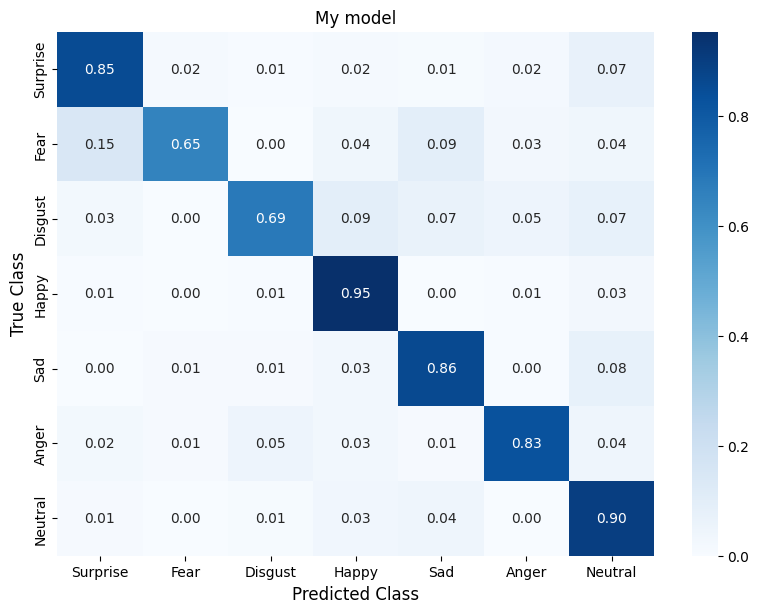

              precision    recall  f1-score   support

    Surprise       0.89      0.85      0.87       329
        Fear       0.76      0.65      0.70        74
     Disgust       0.80      0.69      0.74       160
       Happy       0.94      0.95      0.95      1185
         Sad       0.88      0.86      0.87       478
       Anger       0.84      0.83      0.83       162
     Neutral       0.84      0.90      0.87       680

    accuracy                           0.89      3068
   macro avg       0.85      0.82      0.83      3068
weighted avg       0.89      0.89      0.89      3068



In [11]:
plot_confusion_matrix(model, test_loader_ttau)

<h1>5.2. line charts for  training process</h1>

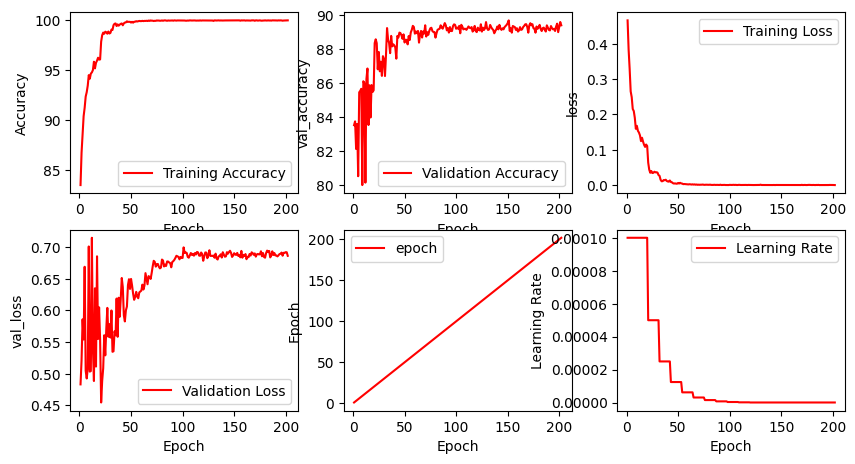

In [12]:
training_process_statistic(rs_path='/kaggle/working/out.csv')